# Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('../data/raw/Data.csv', header=None, encoding='ISO-8859-1')

In [3]:
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']


In [4]:
df = df[['target', 'text']]

In [5]:
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


<Axes: xlabel='target', ylabel='Count'>

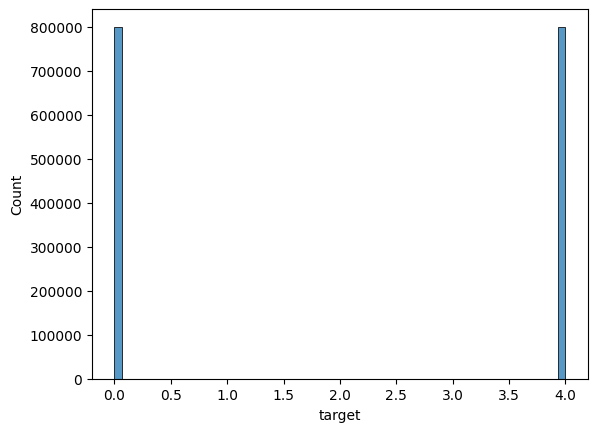

In [6]:
sns.histplot(data=df, x='target')

Tengo igual cantidad de tuits positivos que negativos, indicandome esto que no me encuentro ante un problema de disparidad

### Procesamiento de texto

In [7]:
import re

def preprocess_text(text):
    
    # Quitar las URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Eliminar menciones
    text = re.sub(r'@\w+', '', text)

    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-zA-Z0-9 ]', " ", text)

    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

df["text"] = df["text"].apply(preprocess_text)
df.head()

,target,text
0,0,"[that, a, bummer, you, shoulda, got, david, ca..."
1,0,"[is, upset, that, he, can, update, his, facebo..."
2,0,"[dived, many, times, for, the, ball, managed, ..."
3,0,"[my, whole, body, feels, itchy, and, like, its..."
4,0,"[no, it, not, behaving, at, all, m, mad, why, ..."


In [8]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

df["text"] = df["text"].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /home/carlos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/carlos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,text
0,0,"[bummer, shoulda, david, carr, third]"
1,0,"[upset, update, facebook, texting, might, resu..."
2,0,"[dived, many, time, ball, managed, save, rest,..."
3,0,"[whole, body, feel, itchy, like, fire]"
4,0,[behaving]


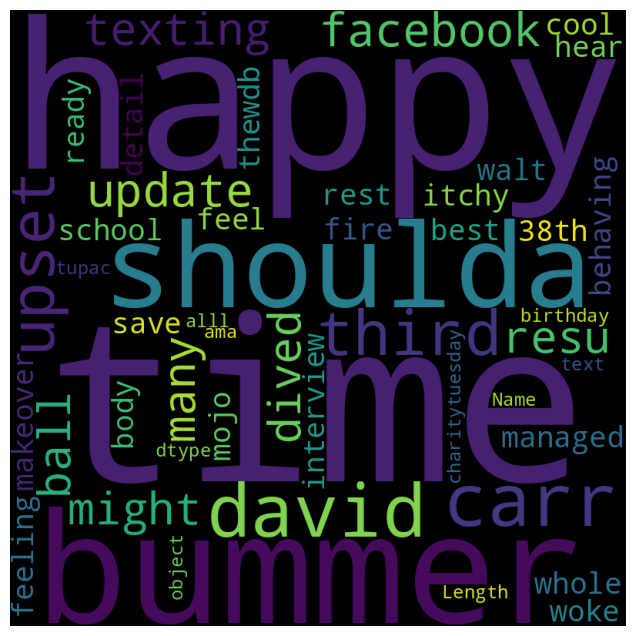

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(df["text"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Vectorizacion de palabras (Word2Vec)

In [10]:
from gensim.models import Word2Vec

# Entrenar el modelo
model = Word2Vec(sentences=df["text"], vector_size=100, window=5, min_count=1, workers=4)

In [11]:
# Obtener vector de una palabra
vector = model.wv["happy"]

# Palabras más similares
similares = model.wv.most_similar("happy", topn=5)

# Ver vocabulario aprendido
vocabulario = list(model.wv.index_to_key)

In [12]:
similares

[('83rd', 0.5770695209503174),
 ('yumtastical', 0.5770321488380432),
 ('2mozxxmuch', 0.5755089521408081),
 ('birthquake', 0.5711216330528259),
 ('marstini', 0.5695613622665405)]

In [13]:
# Guardar
model.save("../models/word2vec_tweets.model")

# Cargar
#model = Word2Vec.load("word2vec_tweets.model")

In [14]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

2025-04-07 21:10:20.154784: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 21:10:20.168351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744053020.178908   44546 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744053020.181770   44546 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744053020.192319   44546 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 2. Crear word_index y embedding_matrix

In [15]:
word_vectors = model.wv
vocab = word_vectors.index_to_key
word_index = {word: i for i, word in enumerate(vocab)}
embedding_matrix = word_vectors.vectors
vocab_length = len(vocab)

### 3. Convertir texto a secuencias de índices

In [16]:
def text_to_sequence(tokens, word_index):
    return [word_index[word] for word in tokens if word in word_index]

df["seq"] = df["text"].apply(lambda x: text_to_sequence(x, word_index))

### 4. Padding

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_len = max(df["seq"].apply(len))
X_padded = pad_sequences(df["seq"], maxlen=max_len, padding='post')

### Normalizo y defino mi target


In [18]:
df['target'] = df['target'].replace({4: 1})
y = df['target'].values

### Entrenamiento modelo CNN

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

Mi red neuronal

In [30]:
cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_len, trainable=False)
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['acc'])

/home/carlos/miniconda3/envs/tf-wsl/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [31]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │    25,694,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,694,700 (98.02 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25,694,700 (98.02 MB)

In [32]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

print("¿Hay None en X_train?", any(x is None for x in X_train))
print("¿Hay None en y_train?", any(x is None for x in y_train))

X_train shape: (1280000, 30)
y_train shape: (1280000,)
X_test shape: (320000, 30)
y_test shape: (320000,)
¿Hay None en X_train? False
¿Hay None en y_train? False


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Añado early stopping ya que mi mejor epoch es el numero 7
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = cnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
39995/40000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.6971 - loss: 0.5786